# - Détection de FakeNews


# NLP + Machine Learning


### Imports généraux

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from sklearn.naive_bayes import MultinomialNB
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Charger le fichier
df = pd.read_csv("/content/fake_news_sample_categorised.csv")

# Afficher les noms de colonnes
print(" Colonnes disponibles dans le fichier :")
print(df.columns.tolist())

# Aperçu des 5 premières lignes
print("\n Aperçu du contenu :")
print(df.head())

 Colonnes disponibles dans le fichier :
['post', 'post_clean', 'fake', 'avg_word_length', 'stopword_ratio', 'hapax_ratio', 'id_categorie', 'word_count', 'char_count', 'sentence_count', 'avg_sentence_length', 'uppercase_ratio', 'punctuation_count', 'has_question', 'has_exclamation', 'contains_url', 'subjectivity', 'polarity', 'tfidf_keywords_top3', 'readability_score', 'pos_verb_ratio', 'pos_noun_ratio', 'repeated_words_ratio', 'title_case_word_ratio', 'language_detected', 'categorie']

 Aperçu du contenu :
                                                post  \
0  Sénatoriales : les résultats des élections.La ...   
1                 Live Spécial François Fillon\r\n27   
2  Notre-Dame-des-Landes : « La décision prise pa...   
3  Chasse: silence, on tire.Avec l'autorisation d...   
4  Payet lance un appel à l’OM : « S’il vous plaî...   

                                          post_clean  fake  avg_word_length  \
0  senatoriales resultats elections moitie postes...     0             8

## Étape 1 – Données à utiliser

In [7]:
# Vérification colonnes utiles
X_text = df["post_clean"]
y = df["fake"]

# Échantillonnage si besoin
df_sampled = df.sample(n=5000, random_state=42) if len(df) > 5000 else df
X_text = df_sampled["post_clean"]
y = df_sampled["fake"]

# Vectorisation TF-IDF
vectorizer = TfidfVectorizer(max_features=51984)
X_tfidf = vectorizer.fit_transform(X_text)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Modèle : Régression Logistique
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix (voir graphique ci-dessous) :\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report :\n", classification_report(y_test, y_pred))

Accuracy : 0.915

Confusion Matrix (voir graphique ci-dessous) :
 [[443  57]
 [ 28 472]]

Classification Report :
               precision    recall  f1-score   support

           0       0.94      0.89      0.91       500
           1       0.89      0.94      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.91      1000
weighted avg       0.92      0.92      0.91      1000



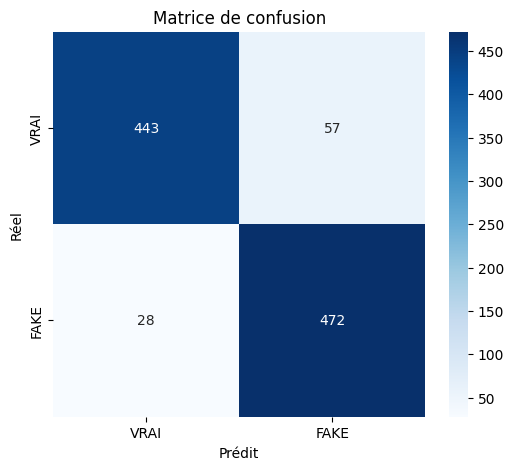

In [8]:
# Affichage graphique de la matrice de confusion
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['VRAI', 'FAKE'], yticklabels=['VRAI', 'FAKE'])
plt.title('Matrice de confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()


Le modèle se débrouille bien : il identifie la grande majorité des fake news sans trop accuser à tort des vraies infos. On atteint environ 92 % de bonnes réponses overall, avec juste un peu plus d’erreurs quand il s’agit de confondre une vraie actu avec une fake.

## Étape 2 – Vectorisation


In [10]:
french_stopwords = stopwords.words('french')

params = {
    'ngram_range': (1, 2),
    'max_features': 5000,
    'stop_words': french_stopwords  # liste de stopwords françaises
}

count_vect = CountVectorizer(**params)
X_count = count_vect.fit_transform(X_text)
print("CountVectorizer shape:", X_count.shape)

tfidf_vect = TfidfVectorizer(**params)
X_tfidf = tfidf_vect.fit_transform(X_text)
print("TfidfVectorizer shape:", X_tfidf.shape)


CountVectorizer shape: (5000, 5000)
TfidfVectorizer shape: (5000, 5000)


## Étape 3 – Modèles à entraîner

In [17]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

def evaluate_model(model, X_test, y_test, vectorizer, top_n=10):
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Pour les modèles linéaires, afficher les top mots prédictifs
    if hasattr(model, "coef_"):
        feature_names = vectorizer.get_feature_names_out()
        coefs = model.coef_[0]

        # Mots les plus positifs (associés à la classe 1 = fake)
        top_pos_indices = np.argsort(coefs)[-top_n:]
        top_pos_words = [(feature_names[i], coefs[i]) for i in reversed(top_pos_indices)]

        # Mots les plus négatifs (associés à la classe 0 = vrai)
        top_neg_indices = np.argsort(coefs)[:top_n]
        top_neg_words = [(feature_names[i], coefs[i]) for i in top_neg_indices]

        print(f"\nTop {top_n} mots associés à la classe FAKE (1):")
        for word, coef in top_pos_words:
            print(f"{word}: {coef:.4f}")

        print(f"\nTop {top_n} mots associés à la classe VRAI (0):")
        for word, coef in top_neg_words:
            print(f"{word}: {coef:.4f}")
    print("\n" + "="*50 + "\n")

# --- Logistic Regression ---
print("Logistic Regression")
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
evaluate_model(lr, X_test, y_test, tfidf_vect)

# --- Multinomial Naive Bayes ---
print("Multinomial Naive Bayes")
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
evaluate_model(mnb, X_test, y_test, tfidf_vect)

Logistic Regression
Accuracy: 0.9140
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       500
           1       0.88      0.95      0.92       500

    accuracy                           0.91      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000

Confusion matrix:
[[437  63]
 [ 23 477]]

Top 10 mots associés à la classe FAKE (1):
machin: 2.3939
corse machin: 2.3854
homme: 2.0888
faire: 1.9545
non classe: 1.8087
decide: 1.5854
video: 1.5724
revelation: 1.5695
septembre: 1.4731
avoir: 1.4510

Top 10 mots associés à la classe VRAI (0):
facebook twitter: -4.9156
partage facebook: -4.8383
partage: -4.8175
twitter: -4.8086
facebook: -3.2991
mardi: -2.4407
mercredi: -2.3957
jeudi: -2.3091
dns: -2.1930
proces: -2.1900


Multinomial Naive Bayes
Accuracy: 0.8910
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       500
           

# Synthèse :     



> Interprétation et Synthèse critique
Après avoir entraîné nos modèles de classification pour différencier les fake news des vraies news, nous avons analysé les résultats et les caractéristiques qui distinguent ces deux catégories.



1. Quels mots sont associés aux fake news ?

Dans le modèle de régression logistique, les mots les plus fortement associés à la classe « fake news » sont des termes comme : machin, corse machin, homme, faire, non classe, décide, vidéo, révélation, septembre, avoir. On remarque que plusieurs de ces mots sont assez vagues ou génériques, ce qui pourrait refléter la nature souvent imprécise ou sensationnaliste des fake news. Par exemple, « machin » est un terme peu précis, « révélation » ou « vidéo » sont souvent utilisés pour attirer l’attention, mais sans forcément garantir la véracité du contenu. Ces mots traduisent donc une tendance à utiliser un vocabulaire accrocheur ou moins factuel, ce qui correspond bien à ce que l’on peut attendre des fake news.

2. Quels mots sont caractéristiques des vraies news ?

À l’inverse, les mots les plus typiques des vraies news sont : facebook twitter, partage facebook, twitter, facebook, mardi, mercredi, jeudi, dns, proces. Ces termes montrent que les vraies informations ont souvent une dimension factuelle plus nette : elles mentionnent des sources précises comme les réseaux sociaux, des dates exactes, ou des notions liées à des événements officiels comme un procès. Cela confirme que les vraies news s’appuient davantage sur des faits vérifiables et des références concrètes.

3. La qualité de prédiction est-elle satisfaisante ?

Les performances du modèle de régression logistique sont globalement bonnes, avec une précision (accuracy) de 91,4 % sur les données de test. Le rappel et la F1-score pour les deux classes sont également équilibrés, ce qui signifie que le modèle détecte bien à la fois les fake news et les vraies news, sans trop d’erreurs. La matrice de confusion montre que les erreurs sont relativement peu nombreuses, avec un léger avantage dans la détection des vraies news. Le modèle de Naive Bayes multinomial est un peu moins performant, avec une précision autour de 89 %, ce qui reste correct mais moins bon que la régression logistique.

4. Synthèse critique de l’approche

Cette méthode basée sur la vectorisation des textes avec CountVectorizer et TfidfVectorizer, en combinant unigrammes et bigrammes, permet de capturer une partie importante de l’information lexicale et contextuelle. Le filtrage des mots vides (stop words) en français évite que des mots fréquents mais peu informatifs polluent le modèle.

L’un des points forts majeurs est la simplicité et l’interprétabilité des modèles linéaires comme la régression logistique. Ils offrent une explication claire en montrant quels mots contribuent le plus à la décision, ce qui est très utile pour comprendre le comportement du modèle et pour valider que celui-ci se base bien sur des éléments pertinents.

Cependant, cette approche a aussi ses limites. Le vocabulaire est limité à 5000 mots, ce qui peut exclure certains termes rares mais potentiellement importants. De plus, la méthode ne tient pas compte du sens profond des phrases ni des relations sémantiques complexes, ce qui est souvent crucial pour différencier les informations vraies des fausses, surtout quand les fake news utilisent des formulations proches des vraies.

Par ailleurs, cette méthode repose uniquement sur le contenu textuel brut. Elle ne prend pas en compte d’autres informations qui pourraient améliorer la détection, comme l’auteur du message, la date, le contexte ou les métadonnées.

Enfin, même si la précision est élevée, il est important de tester la robustesse du modèle sur des jeux de données indépendants et d’utiliser des techniques comme la validation croisée pour s’assurer que les résultats ne sont pas dus à un surapprentissage sur les données d’entraînement.